# INF8111 - Fouille de données


## TP1 Automne 2020 - Duplicate Bug Report Detection

##### Date de remise: 23/05


#### Membres de l'équipe:

    - Guillaume Thibault 1948612 1
    - Julien Witty 1949837 2
    - Marie-Eve Patron 1890562 3
    
##### Deliverables:

Vous devez soumettre deux fichiers distincts à Moodle: 
1. Notebook
2. [Json](https://en.wikipedia.org/wiki/JSON) contenant du contenu de page Web récupéré (bug_reports.json) 
    


## Résumé

En raison de la complexité des systèmes logiciels, les bogues logiciels sont répandus. Les entreprises, en particulier les grandes, utilisent généralement un système de suivi des bogues (BTS), également appelé système de suivi des problèmes, pour gérer et suivre les enregistrements des bogues. Outre les développeurs et les testeurs, de nombreux projets, principalement des projets open source, permettent aux utilisateurs de signaler de nouveaux bogues dans leur BTS. Pour ce faire, les utilisateurs doivent remplir un formulaire avec plusieurs champs. Un sous-ensemble important de ces champs fournissent des données catégorielles et n'acceptent que les valeurs qui vont d'une liste fixe d’options (par exemple, composant, version et produit du système). Deux autres domaines importants sont le résumé et la description. Les utilisateurs sont libres d'écrire quoi que ce soit dans les deux champs et la seule contrainte est que le résumé a un nombre maximum de caractères. La soumission d'un formulaire crée une page, appelée rapport de bogue ou rapport de problème, qui contient toutes les informations sur un bogue.

En raison du manque de communication et de synchronisation, les utilisateurs peuvent ne pas savoir qu'un bogue spécifique a déjà été soumis et le signaler à nouveau. Identifier les rapports de bogues en double est une tâche importante dans les BTS et c'est le sujet de ce TP. Fondamentalement, notre objectif est de développer un système qui comparera un nouveau rapport de bogue avec ceux soumis et les classera en fonction de la similitude textuelle. Cette liste classée sera utilisée par un trieur pour identifier manuellement si un rapport est dupliqué ou non. 



## 2 - Installation

Pour ce TP, vous aurez besoin des librairies `numpy`, `sklearn` et `scipy` (que vous avez sans doute déjà), ainsi que la librairie `nltk`, qui est une libraire utilisée pour faire du traitement du language (Natural Language Processing, NLP)

Installez les libraires en question et exécutez le code ci-dessous :

In [1]:
# Si vous le souhaitez, vous pouvez utiliser anaconda

# pip install --user numpy
# pip install --user sklearn
# pip install --user scipy
# pip install --user nltk
# pip install --user tqdm

#python
import numpy as np
import sklearn
import scipy
import nltk
import tqdm
import nltk
import re
import math
from bs4 import BeautifulSoup
from collections import defaultdict
from scipy import sparse
nltk.download("punkt")
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.corpus import stopwords 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/guillaumethibault/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guillaumethibault/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3 - Jeu de données

Téléchargez l'archive à l'adresse suivante: https://drive.google.com/file/d/14BrFaOiVDIcpjwpm5iAkAy0v_moZyGiP/view?usp=sharing


L'archive contient:
1. test.json: Ce fichier contient les duplicate bug reports qui vont être utilisés pour évaluer notre système.
2. threads: Ce dossier contient le code HTML des bug reports. Chaque fichier HTML est nommé selon le motif **bug_report_id.html**.


L'image ci-dessous illustre un exemple de bug report:


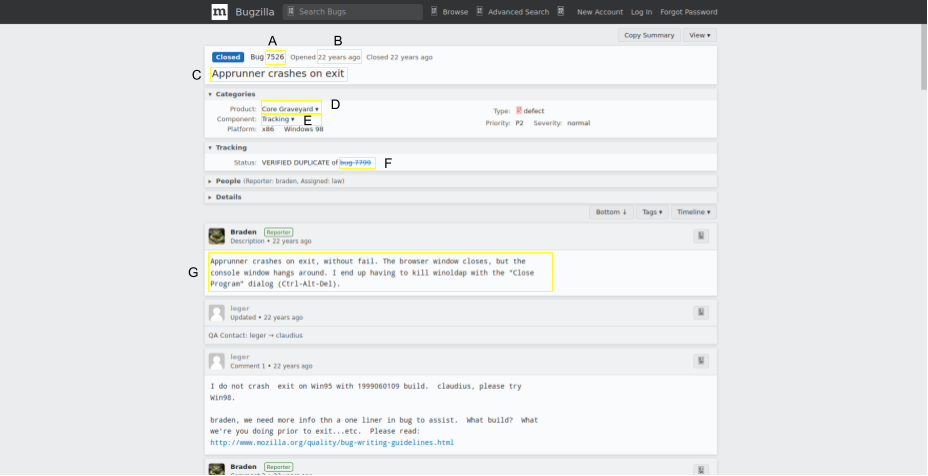

In [2]:
from IPython import display
display.Image("https://irving-muller.github.io/images/bug-report.png")

- A : identifiant du bug report
- B : date de création
- C : résumé
- D : produit
- E : composant
- F : l'identifiant du rapport dont le bug report est dupliqué
- G : description


Le script suivant charge le jeu de données de test et définit certaines variables globales:

In [3]:
import os

# define the folder path that contain the data
# FOLDER_PATH = "Define folder path that contain threads folder and test.json"
FOLDER_PATH = "dataset/"
PAGE_FOLDER = os.path.join(FOLDER_PATH, 'bug_reports')


# Load the evaluation dataset
import json


test = json.load(open(os.path.join(FOLDER_PATH, "test.json")))


# 4 - Web scraping

"Le *web scraping* (parfois appelé harvesting) est une technique d'extraction du contenu de sites Web, via un script ou un programme, dans le but de le transformer pour permettre son utilisation dans un autre contexte, par exemple le référencement." [Wikipedia](https://fr.wikipedia.org/wiki/Web_scraping)

## 4.1 - Question 1 (2 points)

Implémentez la fonction *extract_data_from_page* qui extrait les informations suivantes du code HTML: l'ID du bug report, la date de création, le titre, le produit, le composant, l'ID du bug report dont il est un duplicata, et la description.

La fonction *extract_data_from_page* retourne un dictionnaire avec la structure suivante:

```python
 {"report_id": int, 
  "dup_id": int or None (the report id which it is duplicate), 
  "component": string, 
  "product": string, 
  "summary": str, 
  "description": string, 
  "creation_date": int} 
```

Par exemple, pour le bug report "bug_report/7526.html", la fonction *extract_data_from_page* retourne:

```python
 {"report_id": 7526,
  "dup_id": 7799,
  "product": "core graveyard",
  "component":  tracking,
  "summary": "Apprunner crashes on exit",
  "description": "Apprunner crashes on exit, without fail. The browser window closes, but the console window hangs around. I end up having to kill winoldap with the \"Close Program\" dialog (Ctrl-Alt-Del).",
  "creation_date": 928396140}
```

**La date de création doit être représentée sous la forme d'un timestamp. Si un bug report n'est pas un duplicata, alors dup_id doit être None.**

*Indice: lxml parse est plus rapide que html.parser*

In [4]:
def extract_data_from_page(pagepath) -> dict:
    """
    Scrap bug report content from bug report html.
    
    :param pagepath: the path of html file.
    :return: 
        {
        "report_id": int,
        "dup_id": int or None (the report id which it is duplicate), 
        "component": string, 
        "product": string, 
        "summary": str, 
        "description": string, 
        "creation_date": int
        }
    """
    try:
        data = {}
        with open(pagepath, encoding="utf-8") as fp:
            soup = BeautifulSoup(fp, 'html.parser')
            # report_id 
            data["report_id"] = int(soup.find_all(id="field-value-bug_id")[0].a.string[4:])

            # dup_id
            duplicated_span = soup.find_all(id="field-value-status-view")[0]
            dup_id = None
            if "DUPLICATE" in duplicated_span.text:
                dup_id = int(duplicated_span.a.string[4:])
            data["dup_id"] = dup_id

            # Component
            data["component"] = soup.find_all(id="component-name")[0].text.split("\n")[0]
            data["product"] = soup.find_all(id="product-name")[0].text.split("\n")[0]
            data["summary"] = soup.find_all(id="field-value-short_desc")[0].text
            data["description"] = ''
            for description in soup.find_all("div", {"class": "change-set"}):
                if description.pre is not None:
                    data["description"] = description.pre.text
                    break

            summary = soup.find_all(id="field-value-status_summary")[0]
            data["creation_date"] = int(summary.find_all("span", {"class": "rel-time"})[0]["data-time"])

            return data
    except Exception as e:
        print(f'Exception {epr(e)} in: {pagepath}')
        raise e
            
    



## 4.3 - Extraire le texte du code HTML

In [5]:
import os
from multiprocessing import Pool, TimeoutError
from time import time
import json
import tqdm

# Index each thread by its id
index_path = os.path.join(FOLDER_PATH, 'bug_reports.json')

if os.path.isfile(index_path):
    # Load threads that webpage content were already extracted.
    report_index = json.load(open(index_path))
    print("Json loaded")
else:
    # Extract webpage content

    # This can be slow (around 10 minutes). Test your code with a small sample. lxml parse is faster than html.parser
    files = [os.path.join(PAGE_FOLDER, filename) for filename in os.listdir(PAGE_FOLDER)]
    reports = [extract_data_from_page(f) for f in tqdm.tqdm(files) if f.endswith(".html")]
    report_index = dict(((report['report_id'], report) for report in reports ))

    # Save preprocessed bug reports
    json.dump(report_index, open(index_path,'w'))
    

Json loaded


# 5 - Prétraitement des données

Le prétraitement des données est une tache cruciale en fouille de données. Cette étape nettoie et transforme les données brutes dans un format qui permet leur analyse, et leur utilisation avec des algorithmes de *machine learning*. En traitement des langages (natural language processing, NLP), la *tokenization* et le *stemming* sont des étapes cruciales. De plus, vous implémenterez une étape supplémentaire pour filtrer les mots sans importance.

## 5.1 - Tokenization

Cette étape permet de séparer un texte en séquence de *tokens* (= jetons, ici des mots, symboles ou ponctuation).

Par exemple, la phrase *"It's the student's notebook."* peut être séparé en liste de tokens de cette manière: ["it", " 's", "the", "student", " 's", "notebook", "."].


### 5.1.1 - Question 2 (0.5 point) 

Implémentez la fonction suivante :

- **tokenize_space** qui tokenize le texte à partir des blancs (espace, tabulation, nouvelle ligne). Ce tokenizer est naïf.
- **tokenize_nltk** qui utilise le tokenizer par défaut de la librairie nltk (https://www.nltk.org/api/nltk.html).
- **tokenize_space_punk** replaces the punctuation to space and then tokenizes the tokens that are separated by whitespace (space, tab, newline).

**All tokenizers have to lowercase the tokens.**


In [6]:
def tokenize_space(text: str) -> list:
    """
    Tokenize the tokens that are separated by whitespace (space, tab, newline). 
    We consider that any tokenization was applied in the text when we use this tokenizer.
    
    For example: "hello\tworld of\nNLP" is split in ['hello', 'world', 'of', 'NLP']
    """
    return text.split()

def tokenize_nltk(text) -> list:
    """
    This tokenizer uses the default function of nltk package (word_tokenize) to tokenize the text.(https://www.nltk.org/api/nltk.html) 
    """
    return nltk.word_tokenize(text.lower())


def tokenize_space_punk(text):
    """
    This tokenizer replaces punctuation to spaces and then tokenizes the tokens that are separated by whitespace (space, tab, newline).
    """
    # V1 - Ne separe pas doesn't
#     replace = {}
#     for carac in " !\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~«»¡@÷≠–•∆≈≤≥±":
#         replace[carac] = " "
#     replace = dict((re.escape(key), value) for key, value in replace.items())    # Escape special caracter
#     pattern = re.compile("|".join(replace.keys()))                               # Create a regular expression object with a patter
#     text = pattern.sub(lambda m: replace[re.escape(m.group(0))], text)           # Apply pattern
#     return tokenize_space(text)

    # V2 - Separe: doesn't 
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text.lower())

# Test
# print(f'\n ~~~ Test tokenize_space')
# print(tokenize_space("hello\tworld of\nNLP"))
# print(tokenize_space("This is a cooool, #dummysmiley: :-) :-P <3 and some arrows. < > -> <--"))

# print(f'\n ~~~ Test tokenize_nltk')
# print(tokenize_nltk("hello\tworld of\nNLP"))
# print(tokenize_nltk("This is a cooool, #dummysmiley: :-) :-P <3 and some arrows < > -> <-- but it doesn't tokenize the t"))

# print(f'\n ~~~ Test tokenize_space_punk')
# print(tokenize_space_punk("hello\tworld of\nNLP"))
# print(tokenize_space_punk("This \n is a cooool, #dummysmiley: :-) :-P <3 and some arrows < > -> <-- but it doesn't tokenize the t"))


    

## 5.2 - Stop words removal

### 5.2.1 - Question 3 (0.5 point)

Certains tokens sont sans importance pour la comparaison, car ils apparaissent dans la majorité des discussions. Les supprimer réduit la dimension du vecteur et accélère les calculs.

Expliquez quels tokens sont sans importances pour la comparaison des discussions. Implémentez la fonction filter_tokens qui retire ces mots de la liste des tokens.

*Vous pouvez utiliser un ensemble de mots prédéfini.* 

Réponse question:

Nous allons enlevé les mots les plus communément utilisé comme “the”, “a”, “an”, “in” de la langue anglaise. Pour cela, nous allons utilisé l'ensemble de "stop word" de la librairie nltk.


In [7]:
def filter_tokens(tokens: list):
    stop_words = set(stopwords.words('english')) 
    return [token for token in tokens if not token in stop_words]
    
# Test 
#print(f'\n ~~~ Test filter_tokens')
#print(filter_tokens(['This', 'is', 'a', 'cooool', 'dummysmiley', 'P', '3', 'and', 'some', 'arrows', 'but', 'it', 'doesn', 't', 'tokenize', 'the', 't']))
#print(f'\n -> Tokens sans importance: {set(stopwords.words("english"))}')

## 5.3 - Stemming

La racinisation (stemming) est un procédé de transformation des flexions en leur radical ou racine. Par example, en anglais, la racinisation de "fishing", "fished" and "fish" donne "fish" (stem). 



In [8]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

word1 = ["Visitors", "from", "all", "over", "the", "world", "fishes", "during", "the", "summer","."]

print([ stemmer.stem(w) for w in word1])

word2 = ['I', 'was', 'fishing',]
print([ stemmer.stem(w) for w in word2])

['visitor', 'from', 'all', 'over', 'the', 'world', 'fish', 'dure', 'the', 'summer', '.']
['i', 'was', 'fish']


### 5.3.1 - Question 4 (0.5 point) 

*Expliquez comment et pourquoi le stemming est utile à notre système.*


La racinisation permet de rendre le jeu de données plus dense. en effet, il réduit la taille du dictionnaire de mot en rassemblant les mots de même famille. Cela permet d'optimiser le traitement du language en facilitant les liens potentiel entre les mots. Par la suite, il est possible de faire des analyses statistiques des mots les plus couramment utiliser pour faire une analyse des mots récurrants pour identifier des problèmes potentiels.

Il est important de mentionné que des fois, la racinisation fait en sorte que l'on pert la signification du mot.

# 6 - Représentation des données 

## 6.1 - Bag of Words

De nombreux algorithmes demandent des entrées qui sont toutes de la même taille. Cela n'est pas toujours le cas, notamment pour des données textuelles qui peuvent avoir un nombre variable de mots. 

Par exemple, considérons la phrase 1, ”Board games are much better than video games” et la phrase 2, ”Monopoly is an awesome game!” La table ci-dessous montre un exemple d'un moyen de représentation de ces deux phrases en utilisant une représentation fixe : 

|<i></i>     | an | are | ! | Monopoly | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 1 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |

Chaque colonne représente un mot du vocabulaire (de longueur 13), tandis que chaque ligne contient l'occurrence des mots dans une phrase. Ainsi, la valeur 2 à la position (1,7) est due au mot *"games"* qui apparaît deux fois dans la phrase 1. 

Ainsi, chaque ligne étant de longueur 13, on peut les utiliser comme vecteur pour représenter les phrases 1 et 2. Ainsi, c'est cette méthode que l'on appelle *Bag-of-Words* : c'est une représentation de documents par des vecteurs dont la dimension est égale à la taille du vocabulaire, et qui est construite en comptant le nombre d'occurrences de chaque mot. Ainsi, chaque token est ici associé à une dimension.


La matrice ci-dessus est appelée **document-term matrix**. Chaque cellule de cette matrice représente le nombre de fois qu’un mot particulier (défini par la colonne) apparaît dans un document particulier (défini par la ligne). 


### 6.1.1 - Sparse matrix

Dans les applications réelles, la matrice de termes de document est généralement creuse, c'est-à-dire que la plupart des valeurs sont égales à 0. Pour réduire l'utilisation de la mémoire et accélérer les opérations sur la matrice, les valeurs sont stockées en utilisant des structures de données dans lesquelles seules les entrées non nulles sont conservées. Vous pouvez trouver plus d'informations sur https://en.wikipedia.org/wiki/Sparse_matrix.

Dans ce TP, nous utilisons la compressed sparse row (CSR) pour représenter la document-term matrix. Vous pouvez trouver ci-dessous deux façons de créer une matrice CSR à l'aide de Scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html). 


In [9]:
############################################
# Correct ways to create a csr_matrix
############################################

"""
Example:	hello	world	!	data	mining
document_1	1	2	0	0	0
document_2	0	4	0	5	6
document_3	1	1	3	0	1

[ 1 2 0 0 0
  0 4 0 5 6
  1 1 3 0 1
  ]
"""

from scipy.sparse import csr_matrix
import numpy as np

# One option

data = np.asarray([1.0,2.0,4.0,5.0,6.0,1.0,1.0,3.0,1.0]) # Non-zeroes values
row = np.asarray([0,0,1,1,1,2,2,2,2]) # row of each element
col = np.asarray([0,1,1,3,4,0,1,2,4]) # column of each element
M = csr_matrix((data, (row, col)), shape=(3, 5))
print(M.toarray())


# More efficient option

"""
A figure exemplifies data, indptr, indices in the following link: 
https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr
"""
data = np.asarray([1.0,2.0,4.0,5.0,6.0,1.0,1.0,3.0,1.0]) # Non-zeroes values
indptr = np.array([0, 2, 5, 9]) # (indptr[i-1],indptr[i]) is the column indices in indptr (i.e., indices[indptr[i-1]:indptr[i]]) of the i-th row 
indices = np.array([0,1,1,3,4,0,1,2,4]) # columns indices

M = csr_matrix((data, indices, indptr), shape=(3, 5))
print(M.toarray())

[[1. 2. 0. 0. 0.]
 [0. 4. 0. 5. 6.]
 [1. 1. 3. 0. 1.]]
[[1. 2. 0. 0. 0.]
 [0. 4. 0. 5. 6.]
 [1. 1. 3. 0. 1.]]


Vous pouvez trouver ci-dessous deux méthodes non optimisées pour créer une csr_matrix. **Ils peuvent entraîner des problèmes de mémoire et de performances.** 

In [10]:
############################################
# Wrong ways to create a csr_matrix
############################################

"""
Example:	hello	world	!	data	mining
document_1	1	2	0	0	0
document_2	0	4	0	5	6
document_3	1	1	3	0	1
"""
from scipy.sparse import csr_matrix
import numpy as np

"""
Append 1 to data and the word column index to indices for each time that a word appears in a document
"""
data = np.asarray([1.,1.,1.,   1.,1.,1.,1., 1.,1.,1.,1.,1., 1.,1.,1.,1.,1.,1.,  1.,1.,1.,1.,1.,1.])
indptr = np.array([0, 3, 18, 24])
indices = np.array([0,1,1,  1,1,1,1, 3,3,3,3,3, 4,4,4,4,4,4,   0,1,2,2,2,4]) # columns indices
M = csr_matrix((data, indices, indptr), shape=(3, 5))# Even though it prints the correct matrix, it might be slow and consume a lot of memory 
print(M.toarray())############################################

"""
Use numpy or lists to create csr_matrix. This uses the same amount of memory of a dense matrix
"""
l = np.asarray([[1.,2.,0.,0.,0.],[0.,4.,0.,5.,6.],[1.,1.,3.,0.,1.]])
M = csr_matrix(l)
print(M.toarray())

[[1. 2. 0. 0. 0.]
 [0. 4. 0. 5. 6.]
 [1. 1. 3. 0. 1.]]
[[1. 2. 0. 0. 0.]
 [0. 4. 0. 5. 6.]
 [1. 1. 3. 0. 1.]]


### 6.1.2 - Question 5 (1.5 points)

*Implémentez le Bag-of-Words*

Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf scipy.sparse.csc_matrix.

In [11]:
def transform_count_bow(X):
    """
    This method preprocesses the data using the pipeline object, relates each token to a specific integer and  
    transforms the text in a vector. Vectors are weighted using the token frequencies in the sentence.

    X: document tokens. e.g: [['I','will', 'be', 'back', '.'], ['Hello', 'world', '!'], ['If', 'you', 'insist', 'on', 'using', 'a', 'damp', 'cloth']]

    :return: vector representation of each document
    """
    
    vocab= {}
    i = 0
    text = np.array([np.array(x) for x in X])
    #Vocabulary
    for sentence in text:
        for w in sentence:
            if w not in vocab:
                vocab[w] = i
                i = i + 1
    
    data = []
    ind = 0
    indptr = [ind]
    indices = []
        
    for sentence in text:
        unique, counts = np.unique(sentence, return_counts=True)
        word_occ = dict(zip(unique, counts))
        for word in word_occ:
            data.append(word_occ[word])
            indices.append(vocab[word])
            ind = ind + 1
        indptr.append(ind)
    
    data = np.array(data)
    indptr = np.array(indptr)
    indices = np.array(indices)
      
    T = csr_matrix((data, indices, indptr), shape=(len(X), len(vocab)))
    
    return T.toarray()
    
# Test

"""
Example:	hello	world	!	data	mining
document_1	1	2	0	0	0
document_2	0	4	0	5	6
document_3	1	1	3	0	1
"""
X=[['hello','world', 'world'],
['world', 'world', 'world','world','data','data','data','data','data',
'mining','mining','mining','mining','mining','mining'],
['hello', 'world', '!', '!', '!', 'mining']]
print(transform_count_bow(X))


[[1 2 0 0 0]
 [0 4 5 6 0]
 [1 1 0 1 3]]


## 6.2 - TF-IDF

L'utilisation de la fréquence brute d'apparition des mots, comme c'est le cas avec bag-of-words, peut être problématique. En effet, peu de tokens auront une fréquence très élevée dans un document, et de ce fait, le poids de ces mots sera beaucoup plus grand que les autres, ce qui aura tendance à biaiser l'ensemble des poids. De plus, les mots qui apparaissent dans la plupart des documents n'aident pas à les discriminer. Par exemple, le mot "*de*" apparaît dans beaucoup de documents de la base de données, et pour autant, avoir ce mot en commun ne permet pas de conclure que des documents sont similaires. À l’inverse, le mot "*génial*" est plus rare, mais les documents qui contiennent ce mot sont plus susceptibles d'être positifs. TF-IDF est donc une méthode qui permet de pallier à ce problème.

TF-IDF pondère le vecteur en utilisant une fréquence de document inverse (IDF) et une fréquence de termes (TF).

TF est l'information locale sur l'importance qu'a un mot dans un document donné, tandis que IDF mesure la capacité de discrimination des mots dans un jeu de données. 

L'IDF d'un mot se calcule de la façon suivante:

\begin{equation}
  \text{idf}_i = \log\left( \frac{N}{\text{df}_i} \right),
\end{equation}

avec $N$ le nombre de documents dans la base de donnée, et $\text{df}_i$ le nombre de documents qui contiennent le mot $i$.

Le nouveau poids $w_{ij}$ d'un mot $i$ dans un document $j$ peut ensuite être calculé de la façon suivante:

\begin{equation}
  w_{ij} = \text{tf}_{ij} \times \text{idf}_i,
\end{equation}

avec $\text{tf}_{ij}$ la fréquence du mot $i$ dans le document $j$.



### 6.2.1 - Question 6 (2 points)

Implémentez bag-of-words avec la pondération de TF-IDF

Dans ce TP, nous utilisons la compressed sparse row (CSR) pour représenter la document-term matrix. Vous pouvez trouver ci-dessous deux façons de créer une matrice CSR à l'aide de Scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html). 

In [12]:
def transform_tf_idf_bow(X):
    """
    This method preprocesses the data using the pipeline object, calculates the IDF and TF and 
    transforms the text in vectors. Vectors are weighted using TF-IDF method.

    X: document tokens. e.g: [['I','will', 'be', 'back', '.'], ['Helllo', 'world', '!'], ['If', 'you', 'insist', 'on', 'using', 'a', 'damp', 'cloth']]

    :return: vector representation of each document
    """       
    N = len(X)
    
    tf = transform_count_bow(X)
    
    
    dfi = []
    dfi = np.zeros(len(tf[1]))
    
    for j in range(len(tf[1])):
        for i in range(len(tf)):
            if tf[i][j] > 0:
                dfi[j] = dfi[j] + 1
            
    idf = N/np.array(dfi)
    idf = np.log(idf)

    return np.array(tf) * np.array(idf)
    
# Test
X =  [['I','will', 'be', 'back', '.'], ['Helllo', 'world', '!'], ['If', 'you', 'insist', 'on', 'using', 'a', 'damp', 'cloth']]
print(transform_tf_idf_bow(X))


    
        

[[1.09861229 1.09861229 1.09861229 1.09861229 1.09861229 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.09861229
  1.09861229 1.09861229 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.09861229 1.09861229 1.09861229 1.09861229
  1.09861229 1.09861229 1.09861229 1.09861229]]


# 7 - Our System

## 7.1 - Pipeline


La *pipeline* est la séquence d'étapes de prétraitement des données qui transforme les données brutes dans un format qui permet leur analyse. Pour notre problème, un pipeline est composé des étapes suivantes :

1. Concatène le texte du résumé et de la description.
2. Tokenize le texte, retire les stop words et stem les tokens. 
3. Génère la représentation vectorielle avec transform_tf_idf_bow ou transform_count_bow.
4. Encode les données catégorielles (produit et composant) en nombres entiers.

La pipeline (nlp_pipeline) reçoit une liste de bug reports (dictionnaires) , le type de tokenization, le type de vectorizer, un argument qui active ou désactive les tokens inutiles, et un argument qui active ou désactive le stemming. La fonction *nlp_pipeline* retourne un tuple ($p$, $c$, $M$) tel que :
- $p$ est un vecteur qui contient les valeurs du produit de chaque bug report.
- $c$ est un vecteur qui contient les valeurs du composant de chaque bug report.
- $M$ est une matrice qui contient la représentation du texte de chaque bug report.

Le  $i$-ème élément de $p$, $c$ et $M$ sont le produit, le composant, et la représentation du texte du  $i$-ème rapport dans bug_reports.


In [13]:
def nlp_pipeline(bug_reports, tokenization_type, vectorizer_type, enable_stop_words, enable_stemming):
    """
    Preprocess and vectorize the threads.
    
    bug_reports: list of all bug reports([dict()]).
    tokenization_type: two possible values "space_tokenization" and "nltk_tokenization".
                            - space_tokenization: tokenize_space function is used to tokenize.
                            - nltk_tokenization: tokenize_nltk function is used to tokenize.
                            - space_punk_tokenization: tokenize_space_punk is used to tokenize.
                            
    vectorizer_type: two possible values "count" and "tf_idf".
                            - count: use transform_count_bow to vectorize the text
                            - tf_idf: use transform_tf_idf_bow to vectorize the text
                            
    enable_stop_words: Enables or disables the insignificant stop words removal
    enable_stemming: Enables or disables steming
    
    return: tuple ($p$, $c$, $M$)
    """
    """
    Preprocess and vectorize the threads.
    
    bug_reports: list of all bug reports([dict()]).
    tokenization_type: two possible values "space_tokenization" and "nltk_tokenization".
                            - space_tokenization: tokenize_space function is used to tokenize.
                            - nltk_tokenization: tokenize_nltk function is used to tokenize.
                            - space_punk_tokenization: tokenize_space_punk is used to tokenize.
                            
    vectorizer_type: two possible values "count" and "tf_idf".
                            - count: use transform_count_bow to vectorize the text
                            - tf_idf: use transform_tf_idf_bow to vectorize the text
                            
    enable_stop_words: Enables or disables the insignificant stop words removal
    enable_stemming: Enables or disables steming
    
    return: tuple ($p$, $c$, $M$)
    """
    all_thread_ids = []
    X = []
    
    if tokenization_type == 'space_tokenization':
        tkn_func = tokenize_space
    elif tokenization_type == 'nltk_tokenization':
        tkn_func = tokenize_nltk
    elif tokenization_type == 'space_punk_tokenization':
        tkn_func = tokenize_space_punk
    
    product_vocab = defaultdict(int)
    component_vocab = defaultdict(int)
    
    p = np.zeros((len(bug_reports),))
    c = np.zeros((len(bug_reports),))

    for idx, report in enumerate(bug_reports):
        product_vocab.setdefault(report['product'], len(product_vocab))
        component_vocab.setdefault(report['component'], len(component_vocab))
        
        p[idx] = product_vocab[report['product']]
        c[idx] = component_vocab[report['component']]
                 
        text = report['summary'] +"\n" + report["description"]
        tkns =  tkn_func(text)
        
        if enable_stop_words:
            tkns = filter_tokens(tkns) 
        if enable_stemming:
            tkns = (stemmer.stem(tkn) for tkn in tkns)
                    
        X.append(list(tkns))
        
    print("finish tokenising")
    
    if vectorizer_type == 'count':
        vectorizer_func = transform_count_bow
    elif vectorizer_type == 'tf_idf':
        vectorizer_func = transform_tf_idf_bow
        
    X = vectorizer_func(X)
    print("finish vectorizing")
    
    return p, c, X
    


## 7.2 - Question 7 (1 point)

Implémenter la fonction rank qui renvoie une liste d'index de rapports triés par similitude des rapports de bogue (candidats) et de nouveau rapport de bogue (requête). Nous utilisons la fonction de similarité suivante pour comparer deux rapports de bogues:

$$
\mathrm{SIM}(q,r) = w_1 * F_p(q,r) + w_2 * F_c(q,r) + w_3 * cos\_sim(\mathrm{txt}_q, \mathrm{txt}_c),
$$
$$
 F_p(q,r) = \begin{cases}
    1 ,& \text{if } p_q= p_r\\
    0,              & \text{otherwise},
\end{cases}
$$
$$
 F_c(q,r) = \begin{cases}
    1 ,& \text{if } c_q = c_r\\
    0,              & \text{otherwise},
\end{cases}
$$
où $ c_q $ et $ c_r $ sont la requête et les composants candidats,
  $ p_q $ et $ p_r $ sont la requête et les produits candidats,
  $\mathrm{txt}_q $ et $ \mathrm{txt}_c $ sont la représentation textuelle de la requête et du candidat, et
  $w_1$, $w_2$ et $w_3$ sont des paramètres à régler.

**Dans cette question, la requête doit être supprimée de la liste triée (sortie de classement).**

Vous pouvez utiliser la similitude cosinus d'une bibliothèque (e.g, [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)). Nous vous recommandons également d'effectuer des opérations matricielles.*

In [14]:
def rank(query_idx, p, c, M, w1, w2, w3, F_cossim):
    """
    Return a list of reports indexes sorted by similarity of the bug reports (candidates) and new bug report (query)
    Cosine similarity is used to compare bug reports. 
    
    query_idx: query indexes
    p: product values of all bug reports (list)
    c: component values of all bug reports  (list)
    M: textual data representation of all bug reports  (Matrix)
    
    w1: parameter that controls the impact of the product
    w2: parameter  that controls the impact of the component
    w3: parameter  that controls the impact of textual similrity
    
    return: ranked list of indexes. 
    """

    p_query =  p[query_idx]
    c_query = c[query_idx]
    M_query = M[query_idx]
    Fp = []
    Fc = []
    
    for idx, product in enumerate(p):
        if p_query == product:
            Fp.append(1)
        else:
            Fp.append(0)
    for idx, component in enumerate(c):
        if c_query == component:
            Fc.append(1)
        else:
            Fc.append(0)
    F_sim = w1 * np.array(Fp) + w2 * np.array(Fc) + w3 * np.array(F_cossim)
    pair_idx_sim = list(zip(range(0,len(F_sim)), F_sim))
    pair_idx_sim.sort(key= lambda x: x[1])
    pair_idx_sim.reverse()
    rank_table = []
    for pair in pair_idx_sim:
        rank_table.append(pair[0])
    rank_table.pop(0)
        
    return rank_table  




## 7.3 - Évaluation

Vous allez tester différentes configurations du système de recommandations. Ces configurations seront comparées avec la [mean average precision (MAP) metric](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision). Plus les discussions pertinentes sont recommandées rapidement (c.-à-d. en haut de la liste), plus élevé sera le score MAP. 

Ressources supplémentaires pour comprendre MAP: [recall and precision over ranks](https://youtu.be/H7oAofuZjjE) et [MAP](https://youtu.be/pM6DJ0ZZee0).


La fonction *eval* évalue une configuration spécifique du système

In [15]:
from statistics import mean 


def calculate_map(x):
    res = 0.0
    n = 0.0
    
    for query_id, corrects, candidate_ids in x:
        precisions = []
        for k, candidate_id in enumerate(candidate_ids):
            
            if candidate_id in corrects:
                prec_at_k = (len(precisions) + 1)/(k+1)
                precisions.append(prec_at_k)
                
            if len(precisions) == len(corrects):
                break      
        res += mean(precisions)
        n += 1
    print("finish calculate_map")
    return res/n
            

def eval(tokenization_type, vectorizer, enable_stop_words, enable_stemming, w1, w2, w3):
    reports = [r for r in report_index.values()]
    report_ids = [r["report_id"] for r in report_index.values()]
    prod_v, comp_v, M = nlp_pipeline(reports, tokenization_type, vectorizer, enable_stop_words, enable_stemming)
    report2idx = dict([(r['report_id'], idx) for idx,r in enumerate(reports)])
    rank_lists = []
    cos_sim = sklearn.metrics.pairwise.cosine_similarity(M)
    for query_id, corrects in test:
        query_idx =  report_ids.index(query_id)
        candidate_idxs = rank(query_idx, prod_v, comp_v, M, w1, w2, w3, np.array(cos_sim)[:, query_idx])
        candidate_ids = [ report_ids[idx] for idx in candidate_idxs]
                
        rank_lists.append((query_id, corrects, candidate_ids))
        
    print('Finish eval')
    return calculate_map(rank_lists) 


In [16]:
report_ids = [r["report_id"] for r in report_index.values()]
print(report_ids)       

[1000, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 1001, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 1002, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 1003, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 1004, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 1005, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 1006, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 1007, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 1008, 10081, 10082, 10083, 10084, 10085, 10086, 10087, 10088, 10089, 1009, 10090, 10091, 10092, 10093, 10094, 10095, 10096, 10098, 10099, 101, 1010, 10100, 10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109, 1011, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118, 10119, 1012, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10129, 1013, 10130, 10131, 

## 7.4 - Question 8 (2 points)


Évaluez la précision (MAP) du système avec chacune des configurations suivantes :

1. count(BoW) + space_tokenization
2. count(BoW) + nltk_tokenization
3. count(BoW) + space_punk_tokenization
4. count(BoW) + space_punk_tokenization + Stop words removal
5. count(BoW) + space_punk_tokenization + Stop words removal + Stemming
6. tf_idf + space_punk_tokenization
7. tf_idf + space_punk_tokenization + Stop words removal
8. tf_idf + space_punk_tokenization + Stop words removal + Stemming 

*Dans toutes les configurations, vous devez utiliser $ w_1 = 0.1 $, $ w_2 = 0.1 $ et $ w_3 = 2.0 $.*


**Également, décrivez et comparez les résultats que vous avez trouvés et répondez aux questions suivantes:**

Toutes les versions des algorithmes ont données des valeurs supérieures aux valeurs attendues. Le space tokenization et le nktl tokenization donne respectivement: 0.09184 et 0.0972. On remarque que l'algorithme de la librairie est légèrement plus efficace. Toutefois, le space punk tokenization est clairement meilleur avec un score de 0.1349.

On remarque qu'en ajoutant des étapes au pipeline comme l'étape du stop-word removal ou bien en faisant du stemming sur les tokens, cela améliore considérablement la performance de notre pipeline. La performance de l'algorithme avec le space punk tokenization avec le stopword removal est de 0.1784. Lorsque jumelé avec le stemming, on observe une hausse considérable de 0,3 pour avoir 0.20820. Cela est probablement dû au fait qu'il y a plus de chances d'associer certains mots de différent rapport en utilisant les racines de mots. Le bag of word itf a des performances nettement supérieurs aux tests précédants utilisant le count bag of word. En effet, le bag of word idf permet d'accorder plus de poids au mot peu fréquement utilisé. Nous obtenons un résultat de 0,2176 pour le test utilisant tf_idf et space punk. Encore une fois, le stemming et les stop-word removal ont un impact sur la performance de l'algorithme. Toutefois, il n'y a pas une grosse différence entre les résultat du test 6 et 7, car la mesure de poids permet déjà de moins prendre en compte les mots qui sont présents dans la plupart des textes.

L'algorithme donnant le meilleur résultat est le 8.


- Pourquoi pensez-vous que space_punk_tokenization obtient de meilleurs résultats que les deux autres stratégies de tokenisation?

Le fait de remplacer la pointuation par des espaces et ensuite de faire la tokenisation, peut améliorer considérablement la performance, car la taille des tokens est considérablement réduite. Dans les deux autres méthodes, la ponctuation était un élément des listes tokenisés. Deplus, retirer la ponctuation n'aura pas un gros impact sur le sens des phrases et l'analyse de la similitude.


- Pourquoi la suppression des stop words n'est-elle pas clairement efficace dans les configurations TF-IDF?

Cela vient du fait que les matrice TF-IDF utilise une mesure de poids pour les différents mots. De ce fait, les stops-word n'auront pas un gros poid puisqu'ils appairaissent souvent dans un texte et par le fait même peu d'impact dans l'analyse.

**Chaque performance inférieure aux valeurs MAP suivantes sera pénalisée de 0.2 points** 

1. count(BoW) + space_tokenization: 0.086 
2. count(BoW) + nltk_tokenization: 0.092
3. count(BoW) + space_punk_tokenization: 0.130
4. count(BoW) + space_punk_tokenization + Stop words removal: 0.170
5. count(BoW) + space_punk_tokenization + Stop words removal + Stemming: 0.195
6. tf_idf + space_punk_tokenization: 0.210
7. tf_idf + space_punk_tokenization + Stop words removal: 0.210
8. tf_idf + space_punk_tokenization + Stop words removal + Stemming: 0.217


In [17]:

w1, w2, w3 = 0.1, 0.1, 2.0
# Result1 = eval("space_tokenization", "count", False , False , w1, w2, w3)
# print("1. count(BoW) + space_tokenization: ",Result1 )

Result2 = eval("nltk_tokenization", "count", False , False , w1, w2, w3)
print("2. count(BoW) + nltk_tokenization:",Result2 )

Result3 = eval("space_punk_tokenization", "count", False, False, w1,w2,w3)
print("3. count(BoW) + space_punk_tokenization: ",Result3)

Result4 = eval("space_punk_tokenization", "count", True, False, w1,w2,w3)
print("4. count(BoW) + space_punk_tokenization + Stop words removal: ", Result4)

Result5 = eval("space_punk_tokenization", "count", True, True, w1,w2,w3)
print("5. count(BoW) + space_punk_tokenization + Stop words removal + Stemming: ", Result5)

Result6 = eval("space_punk_tokenization", "tf_idf", False, False, w1,w2,w3)
print("6. tf_idf + space_punk_tokenization: ", Result6)

Result7 = eval("space_punk_tokenization", "tf_idf", True, False, w1,w2,w3)
print(" 7. tf_idf + space_punk_tokenization + Stop words removal:", Result7)

Result8 = eval("space_punk_tokenization", "tf_idf", True, True, w1,w2,w3)
print("8. tf_idf + space_punk_tokenization + Stop words removal + Stemming:",Result8)


finish tokenising
finish vectorizing
Finish eval
finish calculate_map
2. count(BoW) + nltk_tokenization: 0.09723134797784952
finish tokenising
finish vectorizing
Finish eval
finish calculate_map
3. count(BoW) + space_punk_tokenization:  0.13493830932733536
finish tokenising
finish vectorizing
Finish eval
finish calculate_map
4. count(BoW) + space_punk_tokenization + Stop words removal:  0.17842104238260006
finish tokenising
finish vectorizing
Finish eval
finish calculate_map
5. count(BoW) + space_punk_tokenization + Stop words removal + Stemming:  0.20820721603320413
finish tokenising
finish vectorizing
Finish eval
finish calculate_map
6. tf_idf + space_punk_tokenization:  0.21769074289924878
finish tokenising
finish vectorizing
Finish eval
finish calculate_map
 7. tf_idf + space_punk_tokenization + Stop words removal: 0.2145281447137983
finish tokenising
finish vectorizing
Finish eval
finish calculate_map
8. tf_idf + space_punk_tokenization + Stop words removal + Stemming: 0.220792155

1. count(BoW) + space_tokenization:  0.09184499763316356
2. count(BoW) + nltk_tokenization: 0.09723134797784952
3. count(BoW) + space_punk_tokenization:  0.13493830932733536
4. count(BoW) + space_punk_tokenization + Stop words removal:  0.17842104238260006
5. count(BoW) + space_punk_tokenization + Stop words removal + Stemming:  0.20820721603320413
6. tf_idf + space_punk_tokenization:  0.21769074289924878
7. tf_idf + space_punk_tokenization + Stop words removal: 0.2145281447137983
8. tf_idf + space_punk_tokenization + Stop words removal + Stemming: 0.2207921555722159